In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import stats

from matplotlib.backends.backend_pdf import PdfPages

## Get GFP contact matrix

In [2]:
gfp_map = pd.read_csv("../data/gfp_1gfl_contact_matrix.txt", sep='\t', header=None)
# from https://nanohub.org/tools/contactmaps/session?sess=1404740
gfp_map.head()

,0,1,2,3,4,5,6,7,8,9,...,450,451,452,453,454,455,456,457,458,459
0,0.000000,3.805052,6.898267,9.537112,7.954587,8.981441,12.469802,12.754773,12.220778,16.024734,...,31.381256,34.720337,37.042980,40.703995,43.600613,47.219307,48.943333,51.910706,54.906273,56.462132
1,3.805052,0.000000,3.808724,6.617986,6.291074,8.114332,10.905240,11.739250,12.339651,16.044453,...,31.636324,34.768372,36.794243,40.453510,43.133621,46.744904,48.220963,51.103794,54.110416,55.470734
2,6.898267,3.808724,0.000000,3.818772,5.410528,6.373817,8.435843,10.344454,11.564447,14.889733,...,32.065071,35.096848,36.799053,40.494572,42.951889,46.609554,48.003418,50.943794,53.812569,54.929901
3,9.537112,6.617986,3.818772,0.000000,3.766714,5.287507,5.651388,7.551291,9.809889,12.672950,...,29.488104,32.356945,33.805561,37.487530,39.780857,43.437683,44.742664,47.689598,50.490269,51.483883
4,7.954587,6.291074,5.410528,3.766714,0.000000,3.795919,5.428189,5.505925,6.985375,10.364286,...,26.698008,29.764856,31.509750,35.224777,37.753578,41.433640,42.967232,45.994289,48.825912,50.047569


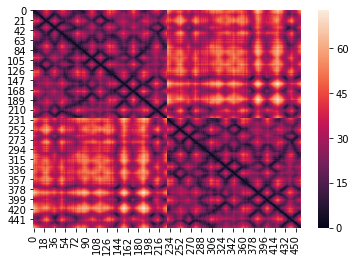

In [3]:
sns.heatmap(gfp_map)

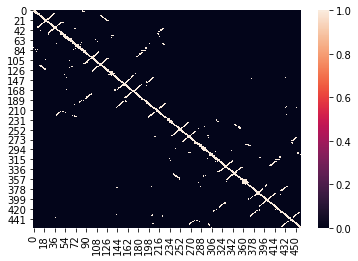

In [4]:
gfp_map_threshold = deepcopy(gfp_map)
gfp_map_threshold[gfp_map_threshold<=8] = 1  # 8 angstroms
gfp_map_threshold[gfp_map_threshold>8] = 0
sns.heatmap(gfp_map_threshold)

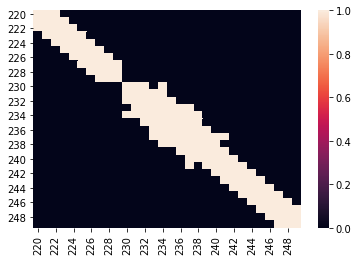

In [5]:
sns.heatmap(gfp_map_threshold.iloc[220:250,220:250])

The PDB says the last 8 residues are missing from the structure so we can safely take 1:230

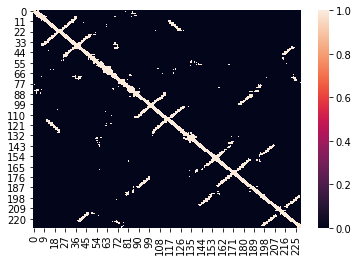

In [6]:
gfp_map_threshold = gfp_map_threshold.iloc[:230,:230]
sns.heatmap(gfp_map_threshold)

We can also apply a minimum separation distance... some papers say minimum 6 residues, others have no separation (but i and j have to be different). let's do 1

In [7]:
for i in range(gfp_map_threshold.shape[0]):
    for j in range(gfp_map_threshold.shape[1]): 
        if np.abs(i-j) < 6:
            gfp_map_threshold.iloc[i,j] = 0

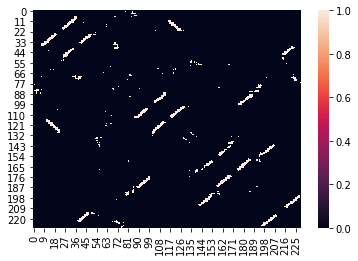

In [9]:
sns.heatmap(gfp_map_threshold)

## Additive effects
Make a linear predictor for fitness

In [8]:
fluor_data = pd.read_csv("../data/amino_acid_genotypes_to_brightness.tsv", sep='\t')
fluor_data.head()

,aaMutations,uniqueBarcodes,medianBrightness,std
0,NaN,3645,3.719212,0.106992
1,SA108D,1,1.301030,NaN
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN
4,SA108G,2,3.708478,0.020613


In [9]:
fluor_data["num_mutations"] = [len(str(x).split(':')) for x in fluor_data["aaMutations"]]
fluor_data.loc[0,"num_mutations"] = 0
fluor_data.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations
0,NaN,3645,3.719212,0.106992,0
1,SA108D,1,1.301030,NaN,1
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,5
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,4
4,SA108G,2,3.708478,0.020613,1


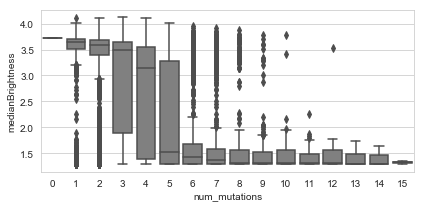

In [148]:
pp = PdfPages("../data/fig1a.pdf")
plt.figure(figsize=[6,3])
sns.boxplot(x="num_mutations", y="medianBrightness", data=fluor_data, color="gray")
plt.tight_layout()
pp.savefig()
pp.close()

In [10]:
init_brightness = fluor_data.loc[0,"medianBrightness"]
fluor_data["delta"] = [x - init_brightness for x in fluor_data["medianBrightness"]]
fluor_data.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta
0,NaN,3645,3.719212,0.106992,0,0.000000
1,SA108D,1,1.301030,NaN,1,-2.418182
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,5,-2.418181
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,4,-2.418023
4,SA108G,2,3.708478,0.020613,1,-0.010734


In [480]:
fluor_data.shape

(54025, 6)

In [11]:
single_mutations = fluor_data[fluor_data["num_mutations"] == 1]
single_mutations.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta
1,SA108D,1,1.301030,NaN,1,-2.418182
4,SA108G,2,3.708478,0.020613,1,-0.010734
10,SA108S,1,3.872970,NaN,1,0.153758
17,SA108T,1,3.137392,NaN,1,-0.581820
34,SA152T,3,3.739811,0.056235,1,0.020598


In [481]:
single_mutations.shape

(1114, 6)

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


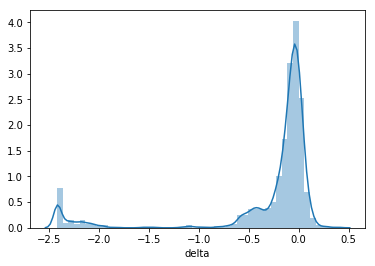

In [14]:
sns.distplot(single_mutations["delta"])

In [12]:
def predict_fluor(x):
    muts = str(x).split(':')
    total_delta = 0
    for mut in muts:
        try: total_delta += float(single_mutations[single_mutations["aaMutations"] == mut]["delta"])
        except: continue
    return total_delta

In [16]:
multiple_mutations = fluor_data[fluor_data["num_mutations"] > 1]
multiple_mutations["predicted_delta"] = [predict_fluor(x) for x in multiple_mutations["aaMutations"]]

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
multiple_mutations.to_csv("../data/181125_multiple_mutations.csv")

In [13]:
multiple_mutations = pd.read_csv("../data/181125_multiple_mutations.csv", index_col=0)

In [14]:
# get rid of proteins where mutations are not in the single mutation data
single_mutation_list = set(list(single_mutations["aaMutations"]))

def in_single_data(mutations):
    muts = str(mutations).split(':')
    for mut in muts:
        if mut not in single_mutation_list: return False
    return True

multiple_mutations_in = multiple_mutations[[in_single_data(x) for x in multiple_mutations["aaMutations"]]]

In [19]:
multiple_mutations_in.shape

(43963, 7)

In [15]:
min_brightness = np.min(multiple_mutations["medianBrightness"])
max_brightness = np.max(multiple_mutations["medianBrightness"])
print(min_brightness, max_brightness, init_brightness)

1.28341923933 4.12310906338 3.7192121319


(0.8528160798701018, 0.0)


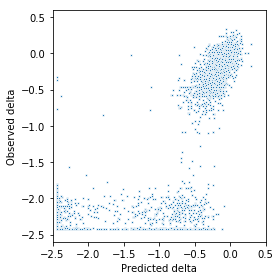

In [41]:
xdata = multiple_mutations_in["delta"]
ydata = multiple_mutations_in["predicted_delta"]

ydata = ydata.apply(lambda x: np.max([x, min_brightness - init_brightness]))
ydata = ydata.apply(lambda x: np.max([x, min_brightness - init_brightness]))

from scipy.stats import spearmanr, pearsonr
print(pearsonr(xdata, ydata))

some_points = np.random.choice(range(len(xdata)), 5000)

pp = PdfPages("../figures/fig1b.pdf")
plt.figure(figsize=[4,4])
sns.scatterplot(x=np.array(ydata)[some_points], y=np.array(xdata)[some_points], s=5)
plt.xlabel("Predicted delta")
plt.ylabel("Observed delta")
plt.xlim([-2.5,0.5])
plt.ylim([-2.6,0.6])
plt.tight_layout()
pp.savefig()
pp.close()

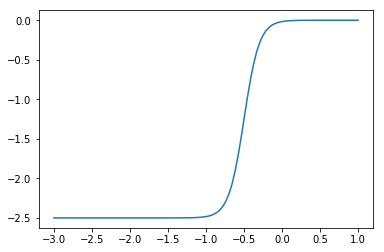

In [18]:
# example of sigmoid data

from scipy.optimize import curve_fit

def sigmoid(x, k, x0, a, b):
    return a / (1 + np.exp(-k * (x - x0))) + b

# data points
x = np.linspace(-3, 1, num=100)
y = sigmoid(x, k=10, x0=-0.5, a=2.5, b=-2.5) 
plt.plot(x,y)

In [19]:
def sigmoid_for_data(x, k, x0):
    b = min_brightness - init_brightness
    a = (max_brightness - init_brightness) - b
    return a  / (1 + np.exp(-k * (x - x0))) + b

[ 7.27958598 -0.46089856  2.32989536 -2.29320123]
(0.9374498318241786, 0.0)


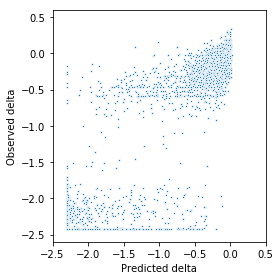

In [39]:
# Plot the fitted curve

# trying to fit a model that changes ydata to xdata
# popt, pcov = curve_fit(sigmoid_for_data, ydata, xdata, p0=[10, -0.5])  
# estimated_k, estimated_x0 = popt

popt, pcov = curve_fit(sigmoid, ydata, xdata, p0=[10, -0.5, 3, 2.5])  
estimated_k, estimated_x0, estimated_a, estimated_b = popt
print(popt)

# y_fitted = [sigmoid_for_data(y, k=estimated_k, x0=estimated_x0) for y in ydata]
y_fitted = [sigmoid(y, k=estimated_k, x0=estimated_x0, a=estimated_a, b=estimated_b) for y in ydata]
print(pearsonr(xdata, y_fitted))

pp = PdfPages("../figures/fig1c.pdf")
plt.figure(figsize=[4,4])
some_points = np.random.choice(range(len(xdata)), 5000)
sns.scatterplot(x=np.array(y_fitted)[some_points], y=np.array(xdata)[some_points], s=5, edgecolors='none')
plt.xlabel("Predicted delta")
plt.ylabel("Observed delta")
plt.xlim([-2.5,0.5])
plt.ylim([-2.6,0.6])
plt.tight_layout()
pp.savefig()
pp.close()

Thus, if we threshold the predicted data and apply a sigmoid function, we can get a bump in R-squared from 0.85 to 0.93 for the whole dataset.

In [44]:
multiple_mutations_in["predicted_delta_thresh"] = ydata
multiple_mutations_in["predicted_delta_thresh_sig"] = y_fitted

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


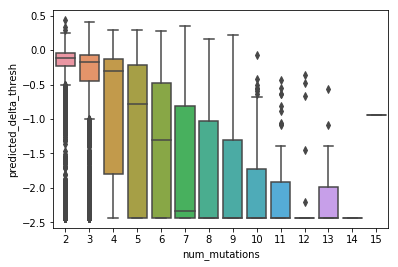

In [27]:
sns.boxplot(x="num_mutations", y="predicted_delta_thresh", data=multiple_mutations_in)

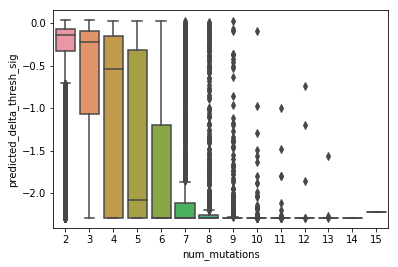

In [28]:
sns.boxplot(x="num_mutations", y="predicted_delta_thresh_sig", data=multiple_mutations_in)

Using single mutation data improves prediction of fitness as compared to just the number of mutations. Using a sigmoidal transformation improves prediction of fitness dramatically. This does not take into account the number of mutations, however.

The problem continues to be that the model is mostly unable to predict cases of severe negative epistasis, where the prediction is around -0.5 but the real delta is -2.5. This is improved considerably with the sigmoid model, but comes at the cost of overpredicting a loss of fitness for proteins that only lose a little bit.

## Pairwise effects
Here we first attempt to explain pairwise mutation data using the contact matrix and contact scores. 

When I ran this initially I found that some mutations e.g. L219P showed up disproportionately in the list of proteins whose fitness deltas were underestimated. This was because we didn't get rid of all proteins with mutations that were not in the single-mutation data. We will now do that.

This was fixed with multiple_mutations_in

In [45]:
two_mutations = multiple_mutations_in[multiple_mutations_in["num_mutations"] == 2]

# positions
pos1_list = []
pos2_list = []
pos1_from_list = []
pos1_to_list = []
pos2_from_list = []
pos2_to_list = []
mut1_list = []
mut2_list = []

for mutations in two_mutations["aaMutations"]:
    [mut1, mut2] = [''.join(list(x)[1:]) for x in mutations.split(':')]
    pos1 = int(''.join(list(mut1[1:-1])))
    pos2 = int(''.join(list(mut2[1:-1])))
    pos1_list.append(pos1)
    pos2_list.append(pos2)
    pos1_from_list.append(list(mut1)[0])
    pos1_to_list.append(list(mut1)[-1])
    pos2_from_list.append(list(mut2)[0])
    pos2_to_list.append(list(mut2)[-1])
    mut1_list.append(mut1)
    mut2_list.append(mut2)
    
two_mutations["pos1"] = pos1_list
two_mutations["pos2"] = pos2_list
two_mutations["pos1_from"] = pos1_from_list
two_mutations["pos1_to"] = pos1_to_list
two_mutations["pos2_from"] = pos2_from_list
two_mutations["pos2_to"] = pos2_to_list
two_mutations["mut1"] = mut1_list
two_mutations["mut2"] = mut2_list

two_mutations.head()

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_thresh,predicted_delta_thresh_sig,pos1,pos2,pos1_from,pos1_to,pos2_from,pos2_to,mut1,mut2
7,SA108G:SK156R,1,3.659013,NaN,2,-0.060199,0.028447,0.028447,-0.027593,108,156,A,G,K,R,A108G,K156R
12,SA108S:SE130G,1,3.767735,NaN,2,0.048523,0.076134,0.076134,-0.009109,108,130,A,S,E,G,A108S,E130G
15,SA108S:SN144D,1,3.631026,NaN,2,-0.088186,0.143170,0.143170,0.008363,108,144,A,S,N,D,A108S,N144D
18,SA108T:SI150V,1,2.633845,NaN,2,-1.085367,-0.605767,-0.605767,-1.691280,108,150,A,T,I,V,A108T,I150V
35,SA152T:SA204G,1,3.621413,NaN,2,-0.097799,-0.130749,-0.130749,-0.156495,152,204,A,T,A,G,A152T,A204G


In [246]:
single_mutation_list = [''.join(list(x)[1:]) for x in list(single_mutations["aaMutations"])]
single_mutation_list[:10]                   

['A108D',
 'A108G',
 'A108S',
 'A108T',
 'A152T',
 'A152V',
 'A177P',
 'A177S',
 'A177T',
 'A177V']

In [436]:
#two_mutations = two_mutations[(two_mutations["mut1"].isin(single_mutation_list)) & (two_mutations["mut2"].isin(single_mutation_list))]
two_mutations.shape  # unfortunately we get rid of 3/4 of the pairwise mutations

(12136, 17)

(0.9250271873942867, 0.0)


/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 216x216 with 0 Axes>

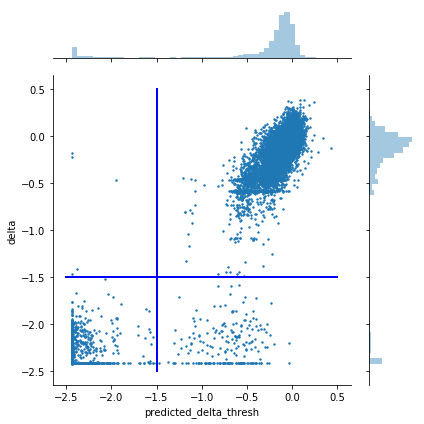

In [46]:
print(stats.pearsonr(two_mutations["delta"], two_mutations["predicted_delta_thresh"]))

pp = PdfPages('../figures/fig1e.pdf')
plt.figure(figsize=[3,3])
g = sns.jointplot(x="predicted_delta_thresh", y="delta", data=two_mutations, joint_kws={"s": 2})
g.ax_joint.plot([-2.5,0.5], [-1.5,-1.5], 'b-', linewidth = 2)
g.ax_joint.plot([-1.5,-1.5], [-2.5,0.5], 'b-', linewidth = 2)
plt.tight_layout()
pp.savefig()
pp.close()

(-0.5, 0.5)

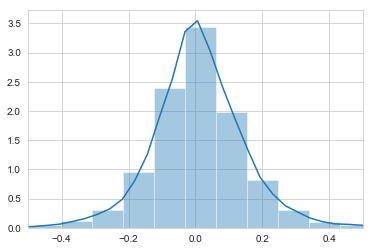

In [438]:
diff = two_mutations["predicted_delta_thresh"] - two_mutations["delta"]
sns.distplot(diff)
plt.xlim(-0.5,0.5)

In [439]:
np.median(diff)

0.006951836110000498

In [100]:
# from https://github.com/Zsailer/latticeproteins/blob/master/latticeproteins/interactions.py
miyazawa_jernigan = {
'CC':-5.44, 'CM':-5.05, 'CF':-5.63, 'CI':-5.03, 'CL':-5.03, 'CV':-4.46, 'CW':-4.76, 'CY':-3.89, 'CA':-3.38, 'CG':-3.16, 'CT':-2.88, 'CS':-2.86, 'CQ':-2.73, 'CN':-2.59, 'CE':-2.08, 'CD':-2.66, 'CH':-3.63, 'CR':-2.70, 'CK':-1.54, 'CP':-2.92,
'MC':-5.05, 'MM':-6.06, 'MF':-6.68, 'MI':-6.33, 'ML':-6.01, 'MV':-5.52, 'MW':-6.37, 'MY':-4.92, 'MA':-3.99, 'MG':-3.75, 'MT':-3.73, 'MS':-3.55, 'MQ':-3.17, 'MN':-3.50, 'ME':-3.19, 'MD':-2.90, 'MH':-3.31, 'MR':-3.49, 'MK':-3.11, 'MP':-4.11,
'FC':-5.63, 'FM':-6.68, 'FF':-6.85, 'FI':-6.39, 'FL':-6.26, 'FV':-5.75, 'FW':-6.02, 'FY':-4.95, 'FA':-4.36, 'FG':-3.72, 'FT':-3.76, 'FS':-3.56, 'FQ':-3.30, 'FN':-3.55, 'FE':-3.51, 'FD':-3.31, 'FH':-4.61, 'FR':-3.54, 'FK':-2.83, 'FP':-3.73,
'IC':-5.03, 'IM':-6.33, 'IF':-6.39, 'II':-6.22, 'IL':-6.17, 'IV':-5.58, 'IW':-5.64, 'IY':-4.63, 'IA':-4.41, 'IG':-3.65, 'IT':-3.74, 'IS':-3.43, 'IQ':-3.22, 'IN':-2.99, 'IE':-3.23, 'ID':-2.91, 'IH':-3.76, 'IR':-3.33, 'IK':-2.70, 'IP':-3.47,
'LC':-5.03, 'LM':-6.01, 'LF':-6.26, 'LI':-6.17, 'LL':-5.79, 'LV':-5.38, 'LW':-5.50, 'LY':-4.26, 'LA':-3.96, 'LG':-3.43, 'LT':-3.43, 'LS':-3.16, 'LQ':-3.09, 'LN':-2.99, 'LE':-2.91, 'LD':-2.59, 'LH':-3.84, 'LR':-3.15, 'LK':-2.63, 'LP':-3.06,
'VC':-4.46, 'VM':-5.52, 'VF':-5.75, 'VI':-5.58, 'VL':-5.38, 'VV':-4.94, 'VW':-5.05, 'VY':-4.05, 'VA':-3.62, 'VG':-3.06, 'VT':-2.95, 'VS':-2.79, 'VQ':-2.67, 'VN':-2.36, 'VE':-2.56, 'VD':-2.25, 'VH':-3.38, 'VR':-2.78, 'VK':-1.95, 'VP':-2.96,
'WC':-4.76, 'WM':-6.37, 'WF':-6.02, 'WI':-5.64, 'WL':-5.50, 'WV':-5.05, 'WW':-5.42, 'WY':-4.44, 'WA':-3.93, 'WG':-3.37, 'WT':-3.31, 'WS':-2.95, 'WQ':-3.16, 'WN':-3.11, 'WE':-2.94, 'WD':-2.91, 'WH':-4.02, 'WR':-3.56, 'WK':-2.49, 'WP':-3.66,
'YC':-3.89, 'YM':-4.92, 'YF':-4.95, 'YI':-4.63, 'YL':-4.26, 'YV':-4.05, 'YW':-4.44, 'YY':-3.55, 'YA':-2.85, 'YG':-2.50, 'YT':-2.48, 'YS':-2.30, 'YQ':-2.53, 'YN':-2.47, 'YE':-2.42, 'YD':-2.25, 'YH':-3.33, 'YR':-2.75, 'YK':-2.01, 'YP':-2.80,
'AC':-3.38, 'AM':-3.99, 'AF':-4.36, 'AI':-4.41, 'AL':-3.96, 'AV':-3.62, 'AW':-3.93, 'AY':-2.85, 'AA':-2.51, 'AG':-2.15, 'AT':-2.15, 'AS':-1.89, 'AQ':-1.70, 'AN':-1.44, 'AE':-1.51, 'AD':-1.57, 'AH':-2.09, 'AR':-1.50, 'AK':-1.10, 'AP':-1.81,
'GC':-3.16, 'GM':-3.75, 'GF':-3.72, 'GI':-3.65, 'GL':-3.43, 'GV':-3.06, 'GW':-3.37, 'GY':-2.50, 'GA':-2.15, 'GG':-2.17, 'GT':-2.03, 'GS':-1.70, 'GQ':-1.54, 'GN':-1.56, 'GE':-1.22, 'GD':-1.62, 'GH':-1.94, 'GR':-1.68, 'GK':-0.84, 'GP':-1.72,
'TC':-2.88, 'TM':-3.73, 'TF':-3.76, 'TI':-3.74, 'TL':-3.43, 'TV':-2.95, 'TW':-3.31, 'TY':-2.48, 'TA':-2.15, 'TG':-2.03, 'TT':-1.72, 'TS':-1.59, 'TQ':-1.59, 'TN':-1.51, 'TE':-1.45, 'TD':-1.66, 'TH':-2.31, 'TR':-1.97, 'TK':-1.02, 'TP':-1.66,
'SC':-2.86, 'SM':-3.55, 'SF':-3.56, 'SI':-3.43, 'SL':-3.16, 'SV':-2.79, 'SW':-2.95, 'SY':-2.30, 'SA':-1.89, 'SG':-1.70, 'ST':-1.59, 'SS':-1.48, 'SQ':-1.37, 'SN':-1.31, 'SE':-1.48, 'SD':-1.46, 'SH':-1.94, 'SR':-1.22, 'SK':-0.83, 'SP':-1.35,
'QC':-2.73, 'QM':-3.17, 'QF':-3.30, 'QI':-3.22, 'QL':-3.09, 'QV':-2.67, 'QW':-3.16, 'QY':-2.53, 'QA':-1.70, 'QG':-1.54, 'QT':-1.59, 'QS':-1.37, 'QQ':-0.89, 'QN':-1.36, 'QE':-1.33, 'QD':-1.26, 'QH':-1.85, 'QR':-1.85, 'QK':-1.02, 'QP':-1.73,
'NC':-2.59, 'NM':-3.50, 'NF':-3.55, 'NI':-2.99, 'NL':-2.99, 'NV':-2.36, 'NW':-3.11, 'NY':-2.47, 'NA':-1.44, 'NG':-1.56, 'NT':-1.51, 'NS':-1.31, 'NQ':-1.36, 'NN':-1.59, 'NE':-1.43, 'ND':-1.33, 'NH':-2.01, 'NR':-1.41, 'NK':-0.91, 'NP':-1.43,
'EC':-2.08, 'EM':-3.19, 'EF':-3.51, 'EI':-3.23, 'EL':-2.91, 'EV':-2.56, 'EW':-2.94, 'EY':-2.42, 'EA':-1.51, 'EG':-1.22, 'ET':-1.45, 'ES':-1.48, 'EQ':-1.33, 'EN':-1.43, 'EE':-1.18, 'ED':-1.23, 'EH':-2.27, 'ER':-2.07, 'EK':-1.60, 'EP':-1.40,
'DC':-2.66, 'DM':-2.90, 'DF':-3.31, 'DI':-2.91, 'DL':-2.59, 'DV':-2.25, 'DW':-2.91, 'DY':-2.25, 'DA':-1.57, 'DG':-1.62, 'DT':-1.66, 'DS':-1.46, 'DQ':-1.26, 'DN':-1.33, 'DE':-1.23, 'DD':-0.96, 'DH':-2.14, 'DR':-1.98, 'DK':-1.32, 'DP':-1.19,
'HC':-3.63, 'HM':-3.31, 'HF':-4.61, 'HI':-3.76, 'HL':-3.84, 'HV':-3.38, 'HW':-4.02, 'HY':-3.33, 'HA':-2.09, 'HG':-1.94, 'HT':-2.31, 'HS':-1.94, 'HQ':-1.85, 'HN':-2.01, 'HE':-2.27, 'HD':-2.14, 'HH':-2.78, 'HR':-2.12, 'HK':-1.09, 'HP':-2.17,
'RC':-2.70, 'RM':-3.49, 'RF':-3.54, 'RI':-3.33, 'RL':-3.15, 'RV':-2.78, 'RW':-3.56, 'RY':-2.75, 'RA':-1.50, 'RG':-1.68, 'RT':-1.97, 'RS':-1.22, 'RQ':-1.85, 'RN':-1.41, 'RE':-2.07, 'RD':-1.98, 'RH':-2.12, 'RR':-1.39, 'RK':-0.06, 'RP':-1.85,
'KC':-1.54, 'KM':-3.11, 'KF':-2.83, 'KI':-2.70, 'KL':-2.63, 'KV':-1.95, 'KW':-2.49, 'KY':-2.01, 'KA':-1.10, 'KG':-0.84, 'KT':-1.02, 'KS':-0.83, 'KQ':-1.02, 'KN':-0.91, 'KE':-1.60, 'KD':-1.32, 'KH':-1.09, 'KR':-0.06, 'KK':0.13, 'KP':-0.67,
'PC':-2.92, 'PM':-4.11, 'PF':-3.73, 'PI':-3.47, 'PL':-3.06, 'PV':-2.96, 'PW':-3.66, 'PY':-2.80, 'PA':-1.81, 'PG':-1.72, 'PT':-1.66, 'PS':-1.35, 'PQ':-1.73, 'PN':-1.43, 'PE':-1.40, 'PD':-1.19, 'PH':-2.17, 'PR':-1.85, 'PK':-0.67, 'PP':-1.18}

In [101]:
gfp_seq = list("MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTL\
VTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLV\
NRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLAD\
HYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK")
# https://www.uniprot.org/uniprot/P42212.fasta

In [102]:
gfp_seq[120]

'N'

# IMPORTANT:

All numbers given in the mutational data are 2 behind. For instance, if A108 is given, then it is actually residue 110 in the protein, so position 109 on the contact map.

In [484]:
two_mutations.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_thresh,predicted_delta_thresh_sig,pos1,pos2,pos1_from,pos1_to,pos2_from,pos2_to,mut1,mut2
7,SA108G:SK156R,1,3.659013,NaN,2,-0.060199,0.028447,0.028447,-0.027593,108,156,A,G,K,R,A108G,K156R
12,SA108S:SE130G,1,3.767735,NaN,2,0.048523,0.076134,0.076134,-0.009109,108,130,A,S,E,G,A108S,E130G
15,SA108S:SN144D,1,3.631026,NaN,2,-0.088186,0.143170,0.143170,0.008363,108,144,A,S,N,D,A108S,N144D
18,SA108T:SI150V,1,2.633845,NaN,2,-1.085367,-0.605767,-0.605767,-1.691280,108,150,A,T,I,V,A108T,I150V
35,SA152T:SA204G,1,3.621413,NaN,2,-0.097799,-0.130749,-0.130749,-0.156495,152,204,A,T,A,G,A152T,A204G


In [103]:
def get_energy(aa1, aa2):
    return miyazawa_jernigan[''.join([aa1, aa2])]

def predict_pairwise_energy_chg(mutations):
    mutations = mutations.split(':')
    
    old_total = 0
    new_total = 0
    for mutation in mutations:
        if '*' in mutation: continue  # not going to predict stop codon mutations
        old_aa = list(mutation)[1]
        new_aa = list(mutation)[-1]
        pos = int(''.join(list(mutation)[2:-1]))  # remember this is 1-indexed, and 2 off
        if pos > gfp_map_threshold.shape[0] - 2: continue  # not going to predict mutations that aren't part of the seq
        #print(old_aa, new_aa, pos)
        
        # get all interactions -- the gfp map is 0-indexed
        interactions = gfp_map_threshold[pos+1]  # need to add 1 to get the real mutated residue!
        for i in range(len(interactions)):
            if interactions[i] == 0: continue
            gfp_aa = gfp_seq[i]

            #print(i, gfp_aa)
            #print(old_aa, gfp_aa, get_energy(old_aa, gfp_aa))
            #print(new_aa, gfp_aa, get_energy(new_aa, gfp_aa))
            old_total += get_energy(old_aa, gfp_aa)
            new_total += get_energy(new_aa, gfp_aa)
            #print(old_total, new_total)
        
    return new_total - old_total  # difference between old and new energies

In [486]:
predict_pairwise_energy_chg("SN119Y")

-14.809999999999995

In [104]:
two_mutations["pairwise_energy_chg"] = [predict_pairwise_energy_chg(x) for x in two_mutations["aaMutations"]]
two_mutations.head()

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_thresh,predicted_delta_thresh_sig,pos1,pos2,pos1_from,pos1_to,pos2_from,pos2_to,mut1,mut2,pairwise_energy_chg
7,SA108G:SK156R,1,3.659013,NaN,2,-0.060199,0.028447,0.028447,-0.027593,108,156,A,G,K,R,A108G,K156R,0.81
12,SA108S:SE130G,1,3.767735,NaN,2,0.048523,0.076134,0.076134,-0.009109,108,130,A,S,E,G,A108S,E130G,1.66
15,SA108S:SN144D,1,3.631026,NaN,2,-0.088186,0.143170,0.143170,0.008363,108,144,A,S,N,D,A108S,N144D,1.73
18,SA108T:SI150V,1,2.633845,NaN,2,-1.085367,-0.605767,-0.605767,-1.691280,108,150,A,T,I,V,A108T,I150V,6.58
35,SA152T:SA204G,1,3.621413,NaN,2,-0.097799,-0.130749,-0.130749,-0.156495,152,204,A,T,A,G,A152T,A204G,2.85


/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


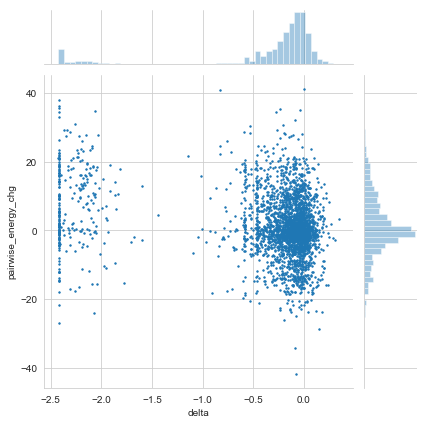

In [488]:
sns.jointplot(x="delta", y="pairwise_energy_chg", data=two_mutations.sample(3000), joint_kws={"s": 2})

In [105]:
low_delta = two_mutations[two_mutations["delta"]<-1.5]["pairwise_energy_chg"]
high_delta = two_mutations[two_mutations["delta"]>-1.5]["pairwise_energy_chg"]
print(np.mean(low_delta))
print(np.mean(high_delta))
print(stats.mannwhitneyu(low_delta, high_delta))

8.340265957446807
0.8547265624999995
MannwhitneyuResult(statistic=3627860.5, pvalue=1.2216992254195706e-117)


In [112]:
delta_category = ["< -1.5" if two_mutations.loc[i]["delta"] < -1.5 else "> -1.5" for i in two_mutations.index]

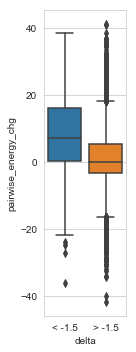

In [146]:
pp = PdfPages("../data/fig1d.pdf")
plt.figure(figsize=[2,5])
sns.boxplot(x=delta_category, y=two_mutations["pairwise_energy_chg"], order=["< -1.5", "> -1.5"])
plt.xlabel("delta")
plt.tight_layout()
pp.savefig()
pp.close()

This makes sense because proteins with a positive contribution to free energy from pairwise interactions are more likely to be less fit.

What if we give this a sigmoid? e.g. proteins with very high pairwise energy changes get penalized in a nonlinear way

In [297]:
import statsmodels.api as sm

In [313]:
# make a linear model with both the individual changes and the pairwise changes

Y = two_mutations["delta"]
#X = two_mutations[["predicted_delta_thresh_sig", "pairwise_energy_chg"]]
X = two_mutations[["predicted_delta_thresh", "pairwise_energy_chg"]]
#X = two_mutations["predicted_delta_thresh_sig"]
#X = two_mutations["predicted_delta_thresh"]
model = sm.OLS(Y,X)

In [314]:
results = model.fit()
preds = results.predict(X)

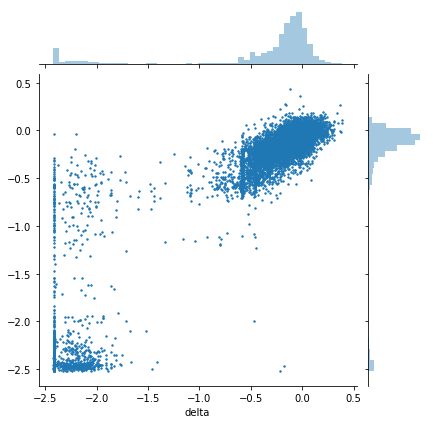

In [315]:
sns.jointplot(x=two_mutations["delta"], y=preds, joint_kws={"s": 2})

In [316]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 4.670e+04
Date:                Sun, 25 Nov 2018   Prob (F-statistic):               0.00
Time:                        21:45:44   Log-Likelihood:                -327.77
No. Observations:               12136   AIC:                             659.5
Df Residuals:                   12134   BIC:                             674.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
predicted_delta_thresh     1.0069      0.003    289.746      0.000       1.000       1.014
pairwise_energy_chg       -0.0018      0.000     -7.334      0.000      -0.002      -0.001
==============================================================================
Omnibus:                    10148.582   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           379573.030
Skew:                          -3.839   Prob(JB):                         0.00
Kurtosis:                      29.300   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [317]:
#preds[preds < min_brightness - init_brightness] = min_brightness - init_brightness
stats.pearsonr(two_mutations["delta"], preds)

(0.9253235490123675, 0.0)

For pairwise:
- just thresholding: r^2 = 0.885
- thresholding with pairwise: r^2 = 0.885
- thresholding with sigmoid: r^2 = 0.835
- thresholding with sigmoid and pairwise: r^2 = 0.836

Thus the sigmoid seems to reduce the predictive ability of the model, and pairwise doesn't really help at all.

- maybe look specifically at the ones that look epistatic? where are those mutations?
- Maybe we look at three-mutation and higher? Maybe it doesn't improve two-mutation but improves three-mutation..
- i also need to take into account the other mutations when calculating interactions
- are the mutations more likely than by chance to interact?

There are a bunch of proteins for which the prediction grossly underestimates the size of the change; what are those?

## Look at poorly predicted pairwise mutations


In [48]:
two_mutations_under = two_mutations[(two_mutations["delta"] < -1.5) & (two_mutations["predicted_delta_thresh"] > -1.5)]
print(two_mutations_under.shape)
two_mutations_under.head()

(208, 17)


,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_thresh,predicted_delta_thresh_sig,pos1,pos2,pos1_from,pos1_to,pos2_from,pos2_to,mut1,mut2
124,SA35T:SF82S,1,1.773462,NaN,2,-1.945751,-0.399097,-0.399097,-0.870538,35,82,A,T,F,S,A35T,F82S
858,SC68S:SK111E,1,1.302106,NaN,2,-2.417106,-0.405290,-0.405290,-0.895633,68,111,C,S,K,E,C68S,K111E
867,SC68S:SK83R,1,1.594072,NaN,2,-2.125140,-0.634239,-0.634239,-1.779097,68,83,C,S,K,R,C68S,K83R
875,SC68S:SN119D,1,1.301031,NaN,2,-2.418181,-0.617018,-0.617018,-1.727115,68,119,C,S,N,D,C68S,N119D
891,SC68Y:SL139Q,1,1.301030,NaN,2,-2.418182,-0.427999,-0.427999,-0.989417,68,139,C,Y,L,Q,C68Y,L139Q


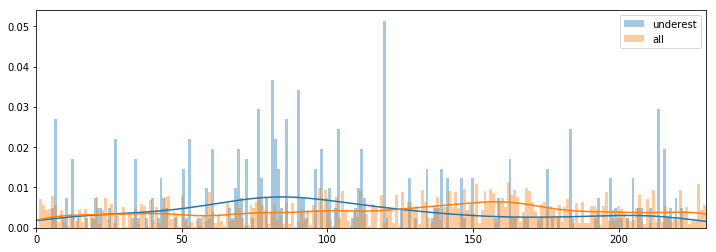

In [123]:
# # which mutations are represented?
# # we assume (will need to check this later) that mutations are distributed equally

# positions
plt.figure(figsize=[12,4])
positions_under = list(two_mutations_under["pos1"])
positions_under.extend(list(two_mutations_under["pos2"]))
sns.distplot(positions_under, bins=230, label="underest")
positions = list(two_mutations["pos1"])
positions.extend(list(two_mutations["pos2"]))
sns.distplot(positions, bins=230, label="all")
plt.xlim([0,230])
plt.legend()

In [320]:
from scipy import stats
stats.ks_2samp(positions_under, positions)

Ks_2sampResult(statistic=0.25009507631458855, pvalue=6.38065472936231e-23)

In [125]:
helices = [[5,8], [37,39], [57,60], [66,69], [74,79], [81,84], [155,158]]
sheets = [[12,22], [25,36], [41,48], [90,98], [103,113], [116,128], 
          [148,154], [160,171], [176,187], [199,208], [217,227]]

In [126]:
from collections import defaultdict
positions_under_domains = defaultdict(lambda: 0)
positions_all_domains = defaultdict(lambda: 0)

# +2 because we are using the map from https://www.researchgate.net/figure/The-primary-structure-and-secondary-structure-map-of-GFP-27-Single-letter-amino_fig1_233915647
# and we know our sequence is 2 bases behind

for pos in positions_under:
    i = 0  # marker of whether i am done
    for dom in helices:
        if i == 0 and pos >= dom[0]+2 and pos <= dom[1]+2:
            i = 1
            positions_under_domains["helices"] += 1
    for dom in sheets:
        if i == 0 and pos >= dom[0]+2 and pos <= dom[1]+2:
            i = 1
            positions_under_domains["sheets"] += 1
    positions_under_domains["other"] += 1
print(positions_under_domains)   

for pos in positions:
    i = 0  # marker of whether i am done
    for dom in helices:
        if i == 0 and pos >= dom[0]+2 and pos <= dom[1]+2:
            i = 1
            positions_all_domains["helices"] += 1
    for dom in sheets:
        if i == 0 and pos >= dom[0]+2 and pos <= dom[1]+2:
            i = 1
            positions_all_domains["sheets"] += 1
    positions_all_domains["other"] += 1
print(positions_all_domains)    

defaultdict(<function <lambda> at 0x1a2907aea0>, {'sheets': 154, 'other': 416, 'helices': 93})
defaultdict(<function <lambda> at 0x1a2907abf8>, {'sheets': 12696, 'other': 24272, 'helices': 3001})


In [491]:
stats.fisher_exact([[93,93+154+416],[3001,3001+24272+12696]])

(1.8682143659504147, 2.029798897899425e-07)

The residues that are involved are more likely to be in helices and less likely to be in sheets and loops.

In [323]:
from collections import Counter
mutation_list = list(two_mutations_under["mut1"])
mutation_list.extend(list(two_mutations_under["mut2"]))
Counter(mutation_list).most_common()[:10]

[('N119D', 12),
 ('V53A', 9),
 ('D214G', 9),
 ('F82S', 8),
 ('Y104H', 8),
 ('D34G', 7),
 ('F112S', 7),
 ('F6S', 7),
 ('F81L', 7),
 ('F98L', 7)]

In [324]:
Counter(positions_under).most_common()[:10]

[(119, 21),
 (81, 15),
 (90, 14),
 (76, 12),
 (214, 12),
 (6, 11),
 (86, 11),
 (183, 10),
 (104, 10),
 (82, 9)]

In [168]:
np.percentile(single_mutations["delta"], 15)

-0.44782983483150013

There are 204 total mutations at position N119 that are involved in pairwise mutations, but only 19 of them were predicted incorrectly. Why is that?

Let's focus on N119D. 12 predicted incorrectly (tops), 37 total (25 predicted correctly). The single mutation delta is -0.445078.

(37, 18)


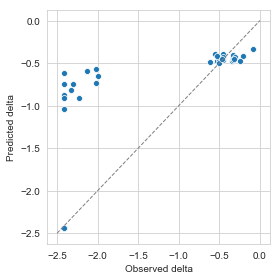

In [183]:
two_mutations_N119D = two_mutations[(two_mutations["mut1"] == "N119D") | (two_mutations["mut2"] == "N119D")]
print(two_mutations_N119D.shape)

pp = PdfPages("../figures/fig2b.pdf")
plt.figure(figsize=[4,4])
g = sns.scatterplot(x="delta", y="predicted_delta_thresh", data=two_mutations_N119D)
plt.xlabel("Observed delta")
plt.ylabel("Predicted delta")
g.plot([-2.5,0], [-2.5,0], '--', color="gray", linewidth = 1)
plt.tight_layout()
pp.savefig()
pp.close()

Initially it looks like almost all the ones that were predicted incorrectly had a second mutation that decreased fitness on its own. There were also some with positive epistasis (did better than predicted additively).

Interestingly, many of these second mutations also show up in the underpredicted list for other mutation partners.

In [366]:
n119d_under = two_mutations_under[(two_mutations_under["mut1"] == "N119D") | (two_mutations_under["mut2"] == "N119D")]
n119d_under

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_thresh,predicted_delta_thresh_sig,pairwise_energy_chg,pos1,pos2,pos1_from,pos1_to,pos2_from,pos2_to,mut1,mut2
875,SC68S:SN119D,1,1.301031,NaN,2,-2.418181,-0.617018,-0.617018,-1.867458,5.12,68,119,C,S,N,D,C68S,N119D
1223,SD101N:SN119D,1,1.394625,NaN,2,-2.324587,-0.818120,-0.818120,-2.172338,0.71,101,119,D,N,N,D,D101N,N119D
4853,SE113G:SN119D,1,1.301064,NaN,2,-2.418148,-0.876935,-0.876935,-2.211105,0.85,113,119,E,G,N,D,E113G,N119D
12516,SF69Y:SN119D,1,1.720193,NaN,2,-1.999020,-0.653341,-0.653341,-1.949358,12.28,69,119,F,Y,N,D,F69Y,N119D
15501,SF98L:SN119D,1,1.699592,NaN,2,-2.019621,-0.739360,-0.739360,-2.091732,2.65,98,119,F,L,N,D,F98L,N119D
29695,SK83R:SN119D,2,1.484348,0.137793,2,-2.234864,-0.907377,-0.907377,-2.225990,-2.33,83,119,K,R,N,D,K83R,N119D
35148,SN119D:SD214N,1,1.301031,NaN,2,-2.418181,-0.744997,-0.744997,-2.098870,0.91,119,214,N,D,D,N,N119D,D214N
35170,SN119D:SI165F,1,1.415850,NaN,2,-2.303362,-0.745750,-0.745750,-2.099805,-1.29,119,165,N,D,I,F,N119D,I165F
35181,SN119D:SK207E,1,1.701241,NaN,2,-2.017971,-0.569858,-0.569858,-1.739504,-1.02,119,207,N,D,K,E,N119D,K207E
35183,SN119D:SL139P,2,1.298334,0.003813,2,-2.420878,-0.904935,-0.904935,-2.224905,13.61,119,139,N,D,L,P,N119D,L139P


 Apparently Asn121 is also in contact with the chromophore as well as Gln69, Gln183, Glu222, and Phe165. 
 https://www.rcsb.org/3d-view/1EMA/1

- Cys70/Phe71: pretty close to the fluorophore
- Asp103/Phe100: at a loop on the chain next to Asn121. Phe100Ser and Phe100Leu both cause almost complete loss of fluorescence, but Phe100Leu is negatively epistatic whereas Phe100Ser is not, suggesting that Asn121Asp destabilizes the chain somewhat and then Phe100Leu completely destabilizes it. (Phe100Ser changes the polarity and bulkiness, Phe100Leu only changes the bulkiness)
- Glu115: entry for protons https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1305344/, on the loop on the opposite side, same chain as Asn121
- Lys85???
- Ile167 is very close to the fluorophore
- Leu141 is at a loop, and Tyr143 there too, on the same chain as Asn121
- Tyr92 also sticks into the chromophore pocket
- Lys209 and Arg216 are at a loop

In [367]:
two_mutations_N119D[~two_mutations_N119D.index.isin(n119d_under.index)]

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_thresh,predicted_delta_thresh_sig,pairwise_energy_chg,pos1,pos2,pos1_from,pos1_to,pos2_from,pos2_to,mut1,mut2
1357,SD115G:SN119D,1,3.513242,NaN,2,-0.205971,-0.419305,-0.419305,-1.190531,-0.49,115,119,D,G,N,D,D115G,N119D
7374,SE32V:SN119D,1,3.203231,NaN,2,-0.515981,-0.462116,-0.462116,-1.362210,-14.26,32,119,E,V,N,D,E32V,N119D
15065,SF97L:SN119D,1,3.379279,NaN,2,-0.339933,-0.470387,-0.470387,-1.394488,3.99,97,119,F,L,N,D,F97L,N119D
15597,SF98S:SN119D,1,1.302501,NaN,2,-2.416711,-2.706507,-2.435793,-2.289673,10.20,98,119,F,S,N,D,F98S,N119D
22100,SI96V:SN119D,1,3.477041,NaN,2,-0.242171,-0.477913,-0.477913,-1.423505,5.22,96,119,I,V,N,D,I96V,N119D
30091,SK99R:SN119D,1,3.192351,NaN,2,-0.526861,-0.478803,-0.478803,-1.426914,-1.56,99,119,K,R,N,D,K99R,N119D
35149,SN119D:SD232G,1,3.387118,NaN,2,-0.332094,-0.465247,-0.465247,-1.374474,0.85,119,232,N,D,D,G,N119D,D232G
35161,SN119D:SH229R,1,3.384082,NaN,2,-0.335130,-0.443832,-0.443832,-1.289643,0.85,119,229,N,D,H,R,N119D,H229R
35166,SN119D:SI126V,1,3.239085,NaN,2,-0.480127,-0.424259,-0.424259,-1.210653,3.92,119,126,N,D,I,V,N119D,I126V
35171,SN119D:SI169T,1,3.168144,NaN,2,-0.551068,-0.390756,-0.390756,-1.074424,10.16,119,169,N,D,I,T,N119D,I169T


Here it makes sense that Y64C (Tyr66) is destabilizing because you need the aromatic ring. You absolutely need Ser65, Tyr66, and Gly67 for the cyclization.

(8, 18)


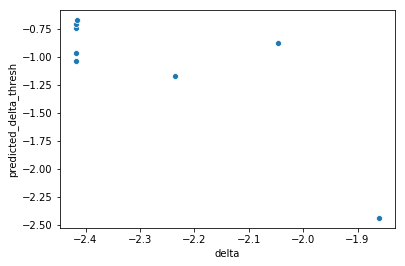

In [288]:
two_mutations_N119D = two_mutations[(two_mutations["mut1"] == "Y90H") | (two_mutations["mut2"] == "Y90H")]
print(two_mutations_N119D.shape)
sns.scatterplot(x="delta", y="predicted_delta_thresh", data=two_mutations_N119D)

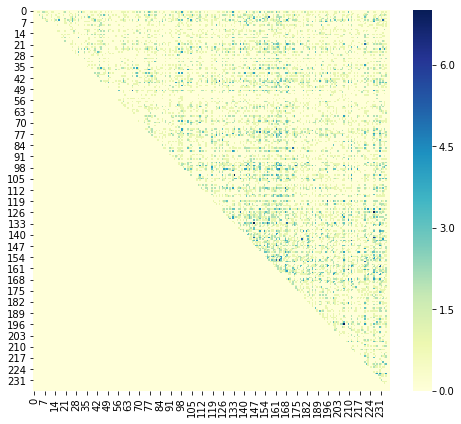

In [332]:
# scatterplot of mutations
changes_all = np.zeros([238,238])
for mutations in two_mutations["aaMutations"]:
    [mut1, mut2] = [''.join(list(x)[1:]) for x in mutations.split(':')]
    pos1 = int(''.join(list(mut1[1:-1])))
    pos2 = int(''.join(list(mut2[1:-1])))
    if pos1 < pos2: 
        changes_all[pos1][pos2] += 1
    else: 
        changes_all[pos2][pos1] += 1
plt.figure(figsize=[8,7])
sns.heatmap(changes_all, cmap="YlGnBu")

In [195]:
sum(changes_all[:,219] + changes_all[219])

83.0

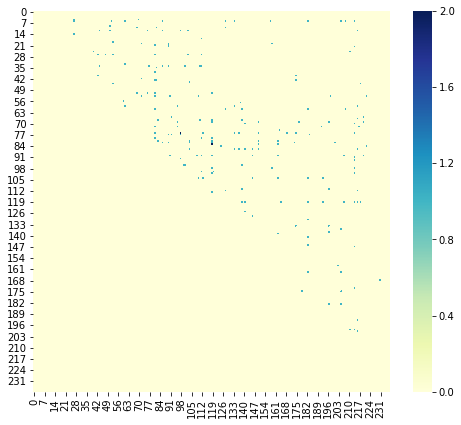

In [329]:
changes = np.zeros([238,238])
for mutations in two_mutations_under["aaMutations"]:
    [mut1, mut2] = [''.join(list(x)[1:]) for x in mutations.split(':')]
    pos1 = int(''.join(list(mut1[1:-1])))
    pos2 = int(''.join(list(mut2[1:-1])))
    if pos1 < pos2: 
        changes[pos1][pos2] += 1
    else: 
        changes[pos2][pos1] += 1
plt.figure(figsize=[8,7])
sns.heatmap(changes, cmap="YlGnBu")

In [495]:
# there has to be something about the pair
# so hydrophilicity of single residues doesn't matter... what about the pair?

hydrophobic = set(['A', 'G', 'V', 'L', 'I', 'P', 'F', 'M', 'W', 'C'])
hydrophilic = set(['D', 'E', 'R', 'K', 'H', 'N', 'Q', 'S', 'T', 'V'])

hydro_changes = defaultdict(lambda: 0)
hydro_changes_pair = defaultdict(lambda: 0)
for i in two_mutations_under.index:
    old1, new1 = two_mutations_under.loc[i]["pos1_from"], two_mutations_under.loc[i]["pos1_to"]
    old1_hydro = "o" if old1 in hydrophobic else "i"
    new1_hydro = "o" if new1 in hydrophobic else "i"
    mut1_chg = ''.join([old1_hydro, new1_hydro])
    
    old2, new2 = two_mutations_under.loc[i]["pos2_from"], two_mutations_under.loc[i]["pos2_to"]
    old2_hydro = "o" if old2 in hydrophobic else "i"
    new2_hydro = "o" if new2 in hydrophobic else "i"
    mut2_chg = ''.join([old2_hydro, new2_hydro])
    
    hydro_changes_pair[tuple(set([mut1_chg, mut2_chg]))] += 1
    hydro_changes[mut1_chg] += 1
    hydro_changes[mut2_chg] += 1
print(hydro_changes_pair)
print(hydro_changes)

defaultdict(<function <lambda> at 0x1c2e913b70>, {('oi',): 12, ('oi', 'ii'): 15, ('oi', 'io'): 28, ('io',): 7, ('ii',): 15, ('oo', 'io'): 11, ('ii', 'io'): 22, ('oi', 'oo'): 36, ('io', 'oo'): 14, ('oo',): 15, ('ii', 'oo'): 25, ('ii', 'oi'): 8})
defaultdict(<function <lambda> at 0x1c354dd598>, {'oi': 111, 'ii': 100, 'io': 89, 'oo': 116})


In [496]:
# these data seem to suggest that these underestimated mutations are likely to be 
# one hydrophobic and one hydrophilic (28+22+36+25=111). but this is also what you 
# would expect by chance (50% of pairs of randomly chosen mutations are likely to be discordant)

# what about the whole set?
hydro_changes_all = defaultdict(lambda: 0)
hydro_changes_pair_all = defaultdict(lambda: 0)
for i in two_mutations.index:
    old1, new1 = two_mutations.loc[i]["pos1_from"], two_mutations.loc[i]["pos1_to"]
    old1_hydro = "o" if old1 in hydrophobic else "i"
    new1_hydro = "o" if new1 in hydrophobic else "i"
    mut1_chg = ''.join([old1_hydro, new1_hydro])
    
    old2, new2 = two_mutations.loc[i]["pos2_from"], two_mutations.loc[i]["pos2_to"]
    old2_hydro = "o" if old2 in hydrophobic else "i"
    new2_hydro = "o" if new2 in hydrophobic else "i"
    mut2_chg = ''.join([old2_hydro, new2_hydro])
    
    hydro_changes_pair_all[tuple(set([mut1_chg, mut2_chg]))] += 1
    hydro_changes_all[mut1_chg] += 1
    hydro_changes_all[mut2_chg] += 1
print(hydro_changes_pair_all)
print(hydro_changes_all)

defaultdict(<function <lambda> at 0x1c2e913378>, {('ii', 'oo'): 1822, ('oi', 'io'): 1036, ('oi', 'ii'): 652, ('oi', 'oo'): 722, ('oi',): 261, ('io', 'oo'): 628, ('io',): 1050, ('oo', 'io'): 705, ('ii', 'io'): 2538, ('ii', 'oi'): 656, ('ii',): 1591, ('oo',): 475})
defaultdict(<function <lambda> at 0x1c351b8400>, {'oo': 4827, 'ii': 8850, 'oi': 3588, 'io': 7007})


MannwhitneyuResult(statistic=1092931.0, pvalue=0.00044911437157412826)


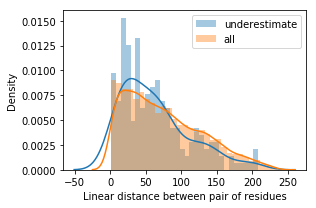

In [49]:
# are these pairs more likely to be closer than all pairs in sequence space? yes

underest_position_diff = []
for mutations in two_mutations_under["aaMutations"]:
    [pos1, pos2] = [int(''.join(list(x)[2:-1])) for x in mutations.split(':')]
    underest_position_diff.append(pos2 - pos1)

all_position_diff = []
for mutations in two_mutations["aaMutations"]:
    [pos1, pos2] = [int(''.join(list(x)[2:-1])) for x in mutations.split(':')]
    all_position_diff.append(pos2 - pos1)
    
print(stats.mannwhitneyu(underest_position_diff, all_position_diff))

pp = PdfPages("../data/fig1f.pdf")
plt.figure(figsize=[4.5,3])
sns.distplot(underest_position_diff, bins=30, label="underestimate")
sns.distplot(all_position_diff, bins=30, label="all")
plt.legend()
plt.xlabel("Linear distance between pair of residues")
plt.ylabel("Density")
plt.tight_layout()
pp.savefig()

In [493]:
print(np.mean(underest_position_diff))
print(np.mean(all_position_diff))

62.625
75.29054054054055


MannwhitneyuResult(statistic=1062202.0, pvalue=4.362783183819554e-05)


/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


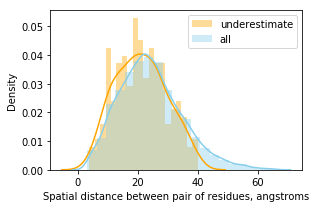

In [59]:
# in terms of actual distance from each other
underest_distance_diff = []
for mutations in two_mutations_under["aaMutations"]:
    [pos1, pos2] = [int(''.join(list(x)[2:-1])) for x in mutations.split(':')]
    try: 
        underest_distance_diff.append(np.abs(gfp_map[pos2+1][pos1+1]))
    except:
        continue
                                       
all_distance_diff = []
for mutations in two_mutations["aaMutations"]:
    [pos1, pos2] = [int(''.join(list(x)[2:-1])) for x in mutations.split(':')]
    try: all_distance_diff.append(np.abs(gfp_map[pos2+1][pos1+1]))
    except: continue
                                  
print(stats.mannwhitneyu(underest_distance_diff, all_distance_diff))

pp = PdfPages("../figures/fig1g_pres.pdf")
plt.figure(figsize=[4.5,3])
sns.distplot(underest_distance_diff, bins=20, label="underestimate", color="orange")
sns.distplot(all_distance_diff, bins=20, label="all", color="skyblue")
plt.legend()
plt.xlabel("Spatial distance between pair of residues, angstroms")
plt.ylabel("Density")
plt.tight_layout()
pp.savefig()
pp.close()

In [494]:
print(np.mean(underest_distance_diff))
print(np.mean(all_distance_diff))

21.084991519267742
24.226747675148687


MannwhitneyuResult(statistic=3978526.0, pvalue=5.67096682314965e-14)


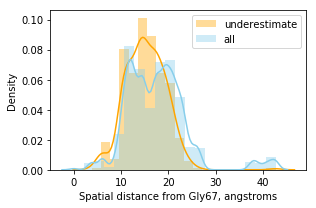

In [60]:
# Distance from residue 66 (the chromophore)
underest_distance_chrom_diff = []
for mutations in two_mutations_under["aaMutations"]:
    [pos1, pos2] = [int(''.join(list(x)[2:-1])) for x in mutations.split(':')]
    try: 
        underest_distance_chrom_diff.append(np.abs(gfp_map[pos1+1][65]))
        underest_distance_chrom_diff.append(np.abs(gfp_map[pos2+1][65]))
    except:
        continue
                                       
all_distance_chrom_diff = []
for mutations in two_mutations["aaMutations"]:
    [pos1, pos2] = [int(''.join(list(x)[2:-1])) for x in mutations.split(':')]
    try: 
        all_distance_chrom_diff.append(np.abs(gfp_map[pos1+1][65]))
        all_distance_chrom_diff.append(np.abs(gfp_map[pos2+1][65]))
    except: continue
                         
pp = PdfPages('../figures/fig2d_pres.pdf')
plt.figure(figsize=[4.5,3])
print(stats.mannwhitneyu(underest_distance_chrom_diff, all_distance_chrom_diff))
sns.distplot(underest_distance_chrom_diff, bins=20, label="underestimate", color="orange")
sns.distplot(all_distance_chrom_diff, bins=20, label="all", color="skyblue")
plt.legend()
plt.xlabel("Spatial distance from Gly67, angstroms")
plt.ylabel("Density")
plt.tight_layout()
pp.savefig()
pp.close()

In [478]:
print(np.mean(underest_distance_chrom_diff))
print(np.mean(all_distance_chrom_diff))

15.209775453003553
17.526704268337237


In [132]:
def get_pval(i):  
    # at residue i, how far are mutations involved in epistasis vs mutations not involved in epistasis?
    underest_distance_chrom_diff = []
    for mutations in two_mutations_under["aaMutations"]:
        [pos1, pos2] = [int(''.join(list(x)[2:-1])) for x in mutations.split(':')]
        try: 
            underest_distance_chrom_diff.append(np.abs(gfp_map[pos1+1][i]))
            underest_distance_chrom_diff.append(np.abs(gfp_map[pos2+1][i]))
        except:
            continue

    all_distance_chrom_diff = []
    for mutations in two_mutations["aaMutations"]:
        [pos1, pos2] = [int(''.join(list(x)[2:-1])) for x in mutations.split(':')]
        try: 
            all_distance_chrom_diff.append(np.abs(gfp_map[pos1+1][i]))
            all_distance_chrom_diff.append(np.abs(gfp_map[pos2+1][i]))
        except: 
            continue

    return stats.mannwhitneyu(underest_distance_chrom_diff, all_distance_chrom_diff).pvalue

In [133]:
pval_dist_from_residue = [-np.log10(get_pval(i)) for i in range(230)]

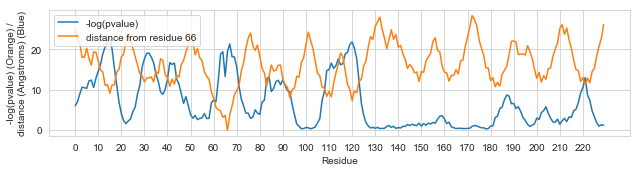

In [138]:
pp = PdfPages('../data/fig1g.pdf')

plt.figure(figsize=[9,2.5])
sns.set_style("whitegrid")
sns.lineplot(x=range(230), y=pval_dist_from_residue, label="-log(pvalue)")
sns.lineplot(x=range(230), y=gfp_map[66][:230], label="distance from residue 66")  # distance from residue 66
plt.xticks([10*x for x in range(23)])
plt.xlabel("Residue")
plt.ylabel("-log(pvalue) (Orange) /\ndistance (Angstroms) (Blue)")
plt.tight_layout()
pp.savefig()
pp.close()

- 10-20 is the chain next to Asn121
- the peaks at 16 and 32 are basically next to Asn121 on different chains
- Low 40s -- right next to the chromophore
- 60s - chromophore

basically we see mutations involved in negative epistasis tend to be closer to residues that are near the chromophore when compared to all mutations involved in double mutated proteins

Interesting areas (that buck the trend): 80-90, 110-120

## Look for sign epistasis

In [34]:
two_mutations.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_thresh,predicted_delta_thresh_sig,pos1,pos2,pos1_from,pos1_to,pos2_from,pos2_to,mut1,mut2
7,SA108G:SK156R,1,3.659013,NaN,2,-0.060199,0.028447,0.028447,-0.027593,108,156,A,G,K,R,A108G,K156R
12,SA108S:SE130G,1,3.767735,NaN,2,0.048523,0.076134,0.076134,-0.009109,108,130,A,S,E,G,A108S,E130G
15,SA108S:SN144D,1,3.631026,NaN,2,-0.088186,0.143170,0.143170,0.008363,108,144,A,S,N,D,A108S,N144D
18,SA108T:SI150V,1,2.633845,NaN,2,-1.085367,-0.605767,-0.605767,-1.691280,108,150,A,T,I,V,A108T,I150V
35,SA152T:SA204G,1,3.621413,NaN,2,-0.097799,-0.130749,-0.130749,-0.156495,152,204,A,T,A,G,A152T,A204G


In [35]:
single_mutations.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta
1,SA108D,1,1.301030,NaN,1,-2.418182
4,SA108G,2,3.708478,0.020613,1,-0.010734
10,SA108S,1,3.872970,NaN,1,0.153758
17,SA108T,1,3.137392,NaN,1,-0.581820
34,SA152T,3,3.739811,0.056235,1,0.020598


In [80]:
from collections import defaultdict
mutation_to_delta = defaultdict(lambda: [])
mutation_to_single = {}
for i in two_mutations.index:
    delta, mut1, mut2 = two_mutations.loc[i]["delta"], two_mutations.loc[i]["mut1"], two_mutations.loc[i]["mut2"]
    mut1_delta = float(single_mutations[single_mutations["aaMutations"] == ''.join(['S', mut1])]["delta"])
    mut2_delta = float(single_mutations[single_mutations["aaMutations"] == ''.join(['S', mut2])]["delta"])
    
    # avoid the ones that were thresholded
    # we cant make any claims about sign epistasis here
    if delta < -2.3 and two_mutations.loc[i]["predicted_delta"] < -3: continue  
        
    mutation_to_delta[mut1].append(delta - mut2_delta)  # to get the mut1 delta
    mutation_to_delta[mut2].append(delta - mut1_delta)  # to tget the mut2 delta
    
    mutation_to_single[mut1] = mut1_delta
    mutation_to_single[mut2] = mut2_delta

In [81]:
df = pd.DataFrame(columns=["mutation", "mean", "sd", "min", "max"])
for mut in mutation_to_delta:
    df = df.append({
        "mutation": mut,
        "single": mutation_to_single[mut],
        "mean": np.mean(mutation_to_delta[mut]),
        "sd": np.std(mutation_to_delta[mut]),
        "min": np.min(mutation_to_delta[mut]),
        "max": np.max(mutation_to_delta[mut])
    }, ignore_index=True)
df

,mutation,mean,sd,min,max,single
0,A108G,-0.099380,0.000000,-0.099380,-0.099380,-0.010734
1,K156R,0.052556,0.105522,-0.325118,0.299871,0.039181
2,A108S,-0.003025,0.077693,-0.077598,0.126147,0.153758
3,E130G,-0.097937,0.181985,-1.273183,0.413822,-0.077624
4,N144D,-0.007441,0.148407,-0.326063,0.646372,-0.010588
5,A108T,-1.061421,0.000000,-1.061421,-1.061421,-0.581820
6,I150V,-0.011669,0.129429,-0.503548,0.215073,-0.023947
7,A152T,-0.022923,0.099171,-0.313592,0.120870,0.020598
8,A204G,-0.121504,0.039401,-0.171238,-0.074877,-0.151348
9,E233G,-0.012079,0.098734,-0.210077,0.247785,-0.007706


In [83]:
sign_epi = 0
for i in df.index:
    if df.loc[i]["max"] > 0.5 and df.loc[i]["min"] < -0.5:
        print(df.loc[i])
        sign_epi += 1
print(sign_epi)
print(sign_epi/1047)

mutation        I159T
mean        -0.132745
sd           0.279516
min          -1.99805
max          0.555283
single     -0.0788286
Name: 79, dtype: object
mutation        Y180C
mean       -0.0325321
sd           0.169585
min         -0.502195
max          0.535534
single     -0.0136721
Name: 94, dtype: object
mutation       F163S
mean        -0.31683
sd          0.475569
min         -2.37823
max          2.20276
single     -0.214747
Name: 97, dtype: object
mutation       D208G
mean        -1.09449
sd          0.808807
min         -2.30721
max         0.556877
single      -1.10533
Name: 199, dtype: object
mutation       H215R
mean         -1.8833
sd          0.830324
min         -2.41432
max         0.509573
single      -2.17839
Name: 285, dtype: object
mutation       V110A
mean       -0.278472
sd           0.37772
min         -1.79939
max         0.897942
single     -0.161513
Name: 430, dtype: object
mutation       L199P
mean         -1.8007
sd          0.925215
min         -2.43437
m

In [86]:
two_mutations_D208G = two_mutations[(two_mutations["mut1"] == "D208G") | (two_mutations["mut2"] == "D208G")]
d208g_delta = []
for i in two_mutations_D208G.index:
    delta, mut1, mut2 = two_mutations_D208G.loc[i]["delta"], two_mutations.loc[i]["mut1"], two_mutations.loc[i]["mut2"]
    mut1_delta = float(single_mutations[single_mutations["aaMutations"] == ''.join(['S', mut1])]["delta"])
    mut2_delta = float(single_mutations[single_mutations["aaMutations"] == ''.join(['S', mut2])]["delta"])
    
    if delta < -2.3 and two_mutations.loc[i]["predicted_delta"] < -3: 
        d208g_delta.append(0)
        continue

    if mut1 == "D208G": 
        d208g_single, other_single = mut1_delta, mut2_delta
        d208g_delta.append((delta - other_single) - d208g_single)
    else: 
        d208g_single, other_single = mut2_delta, mut1_delta
        d208g_delta.append((delta - other_single) - d208g_single)
two_mutations_D208G["d208g_delta"] = d208g_delta
two_mutations_D208G    

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_thresh,predicted_delta_thresh_sig,pos1,pos2,pos1_from,pos1_to,pos2_from,pos2_to,mut1,mut2,d208g_delta
702,SC68R:SD208G,1,1.301032,NaN,2,-2.418180,-3.423393,-2.435793,-2.293200,68,208,C,R,D,G,C68R,D208G,0.000000
1131,SD101E:SD208G,1,3.252769,NaN,2,-0.466443,-1.077413,-1.077413,-2.267297,101,208,D,E,D,G,D101E,D208G,0.610971
3449,SD208G:SL219Q,1,3.137079,NaN,2,-0.582133,-1.076740,-1.076740,-2.267171,208,219,D,G,L,Q,D208G,L219Q,0.494608
3450,SD208G:SY235H,1,2.906263,NaN,2,-0.812949,-1.109407,-1.109407,-2.272631,208,235,D,G,Y,H,D208G,Y235H,0.296458
4826,SE113G:SD208G,1,1.303171,NaN,2,-2.416041,-1.537191,-1.537191,-2.292280,113,208,E,G,D,G,E113G,D208G,-0.878849
11587,SF44S:SD208G,1,1.319176,NaN,2,-2.400037,-1.570194,-1.570194,-2.292476,44,208,F,S,D,G,F44S,D208G,-0.829842
13510,SF6S:SD208G,2,1.315441,0.02038,2,-2.403772,-1.369424,-1.369424,-2.290079,6,208,F,S,D,G,F6S,D208G,-1.034347
15547,SF98S:SD208G,1,1.301031,NaN,2,-2.418181,-3.366764,-2.435793,-2.293200,98,208,F,S,D,G,F98S,D208G,0.000000
30010,SK99R:SD208G,1,2.554247,NaN,2,-1.164965,-1.139060,-1.139060,-2.276596,99,208,K,R,D,G,K99R,D208G,-0.025906
30197,SL123Q:SD208G,1,1.358050,NaN,2,-2.361163,-3.518026,-2.435793,-2.293200,123,208,L,Q,D,G,L123Q,D208G,0.000000


In [65]:
d208g_delta

[-1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201,
 -1.10533426201]

## Look at higher order mutations

### we need to fix this to only take proteins that are fully covered by single mutations

(0.6074257500898022, 0.0)


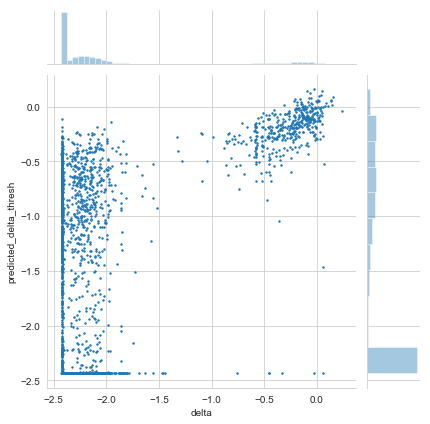

In [440]:
three_mutations = multiple_mutations_in[multiple_mutations_in["num_mutations"] == 3]
more5_mutations = multiple_mutations_in[multiple_mutations_in["num_mutations"] >5]

print(stats.pearsonr(more5_mutations["delta"], more5_mutations["predicted_delta_thresh"]))
sns.jointplot(x="delta", y="predicted_delta_thresh", data=more5_mutations.sample(3000), joint_kws={"s": 2})

(0.8421533566702541, 0.0)


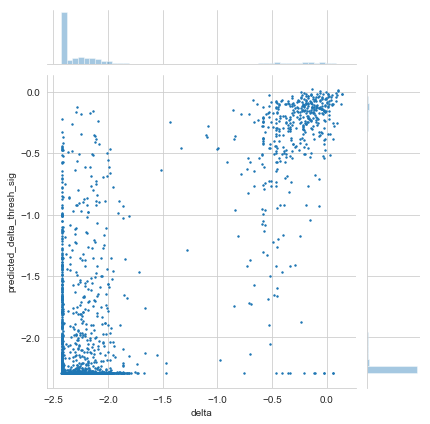

In [441]:
print(stats.pearsonr(more5_mutations["delta"], more5_mutations["predicted_delta_thresh_sig"]))
sns.jointplot(x="delta", y="predicted_delta_thresh_sig", data=more5_mutations.sample(3000), joint_kws={"s": 2})

Clearly for proteins with >2 mutations, adding the sigmoid nonlinearity helps a lot (60.7% to 84.2%)

In [442]:
more5_mutations.shape

(6865, 9)

In [443]:
more5_mutations["pairwise_energy_chg"] = [predict_pairwise_energy_chg(x) for x in more5_mutations["aaMutations"]]
more5_mutations.head()

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_thresh,predicted_delta_thresh_sig,pairwise_energy_chg
11,SA108S:SD127G:SS145G:SQ182R:SN183S:SL205Q,1,1.301030,NaN,6,-2.418182,-0.339398,-0.339398,-0.644220,14.36
20,SA108T:SK156R:SF163L:SV174A:SQ202L:SK207E,1,1.301032,NaN,6,-2.418180,-0.827577,-0.827577,-2.142197,-8.12
102,SA35G:ST60S:SF112S:SN144S:SN162S:SH179R,1,1.301031,NaN,6,-2.418181,-2.973147,-2.435793,-2.293200,20.02
121,SA35T:SE88V:SQ92L:SE109V:SI134V:SD153G:SK156R:...,1,1.302373,NaN,8,-2.416839,-0.747583,-0.747583,-2.036045,-27.16
123,SA35T:SF81S:SF98S:SI134T:SM151L:SQ155R:SK156E:...,1,1.301570,NaN,11,-2.417642,-5.221737,-2.435793,-2.293200,76.27


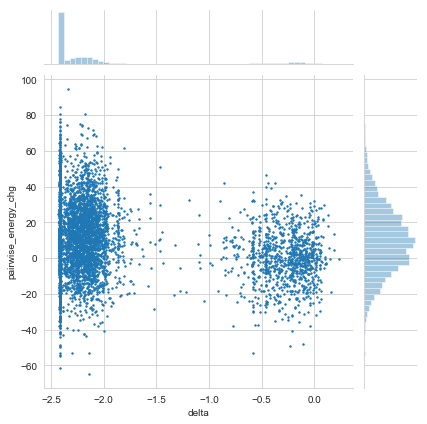

In [444]:
sns.jointplot(x="delta", y="pairwise_energy_chg", data=more5_mutations, joint_kws={"s": 2})

In [470]:
# make a linear model with both the individual changes and the pairwise changes

Y = more5_mutations["delta"]
X = more5_mutations[["predicted_delta_thresh", "pairwise_energy_chg"]]

#X = more5_mutations[["predicted_delta_thresh"]]

#X = more5_mutations["pairwise_energy_chg"]
model = sm.OLS(Y,X)
results = model.fit()
preds = results.predict(X)

In [471]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                 1.879e+04
Date:                Tue, 27 Nov 2018   Prob (F-statistic):               0.00
Time:                        01:03:17   Log-Likelihood:                -8533.0
No. Observations:                6865   AIC:                         1.707e+04
Df Residuals:                    6863   BIC:                         1.708e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
predicted_delta_thresh     1.0386      0.006    160.063      0.000       1.026       1.051
pairwise_energy_chg       -0.0045      0.001     -8.078      0.000      -0.006      -0.003
==============================================================================
Omnibus:                      677.407   Durbin-Watson:                   1.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              653.299
Skew:                          -0.693   Prob(JB):                    1.37e-142
Kurtosis:                       2.398   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

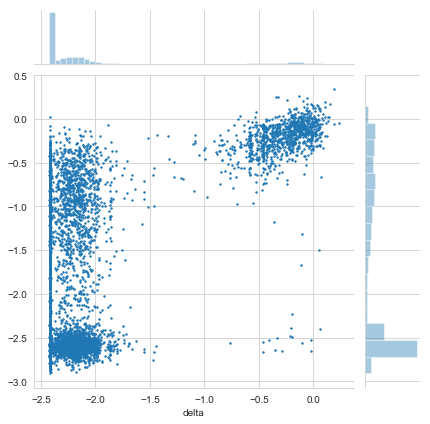

In [472]:
sns.jointplot(x=more5_mutations["delta"], y=preds, joint_kws={"s": 2})

In [473]:
stats.pearsonr(more5_mutations["delta"], preds)

(0.6106661731086481, 0.0)

On t
0.842 to 0.846 if adding pairwise

Conclusion: pairwise epistasis doesn't improve our ability to predict fitness of GFP mutants compared to using single mutants.

# Nonlinear models